# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

## Due: Midnight on October 5th (with 2-hour grace period) and worth 85 points

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **LR schedules**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed / exponential / cosine), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model.

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


## 1. Setup and Data Loading


In [1]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        # print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [3]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 100,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  

In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [5]:
# Reproducible load + preprocess for Intel Image Classification

IMG_SHAPE = (224,224,3)
IMG_SIZE = IMG_SHAPE[:2]

# -------------------------
# Loader (deterministic)
# -------------------------

def load_data_from_directory(directory, img_size=IMG_SIZE, class_names=None, preprocess="mobilenet_v2"):
    """
    Loads images as float32 and integer labels.
    If preprocess == 'mobilenet_v2', outputs are scaled to [-1, 1] as expected by MobileNetV2.
    Else, outputs are scaled to [0,1].
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img).astype("float32")  # values in [0,255]
            if preprocess == "mobilenet_v2":
                # Official Keras preprocessing: scales to [-1, 1]
                arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            else:
                arr = arr / 255.0  # your original behavior
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = np.stack(X).astype("float32")
    y = np.array(y, dtype="int32")
    return X, y, class_names


In [6]:
# Load full training set (preprocessed for MobileNetV2)
X_all, y_all, class_names = load_data_from_directory(
    train_dir, img_size=IMG_SIZE , preprocess="mobilenet_v2"
)

# 80/20 stratified split -> train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=random_seed,
    shuffle=True,
)

# Load test set using same class mapping + preprocessing
X_test, y_test, _ = load_data_from_directory(
    test_dir,
    img_size=IMG_SIZE,
    class_names=class_names
)

num_classes = len(class_names)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

print(f'num_classes: {num_classes}')
print('Class Names:', class_names)

Train: (11227, 224, 224, 3) (11227,)
Val:   (2807, 224, 224, 3) (2807,)
Test:  (3000, 224, 224, 3) (3000,)
num_classes: 6
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Examine The Dataset

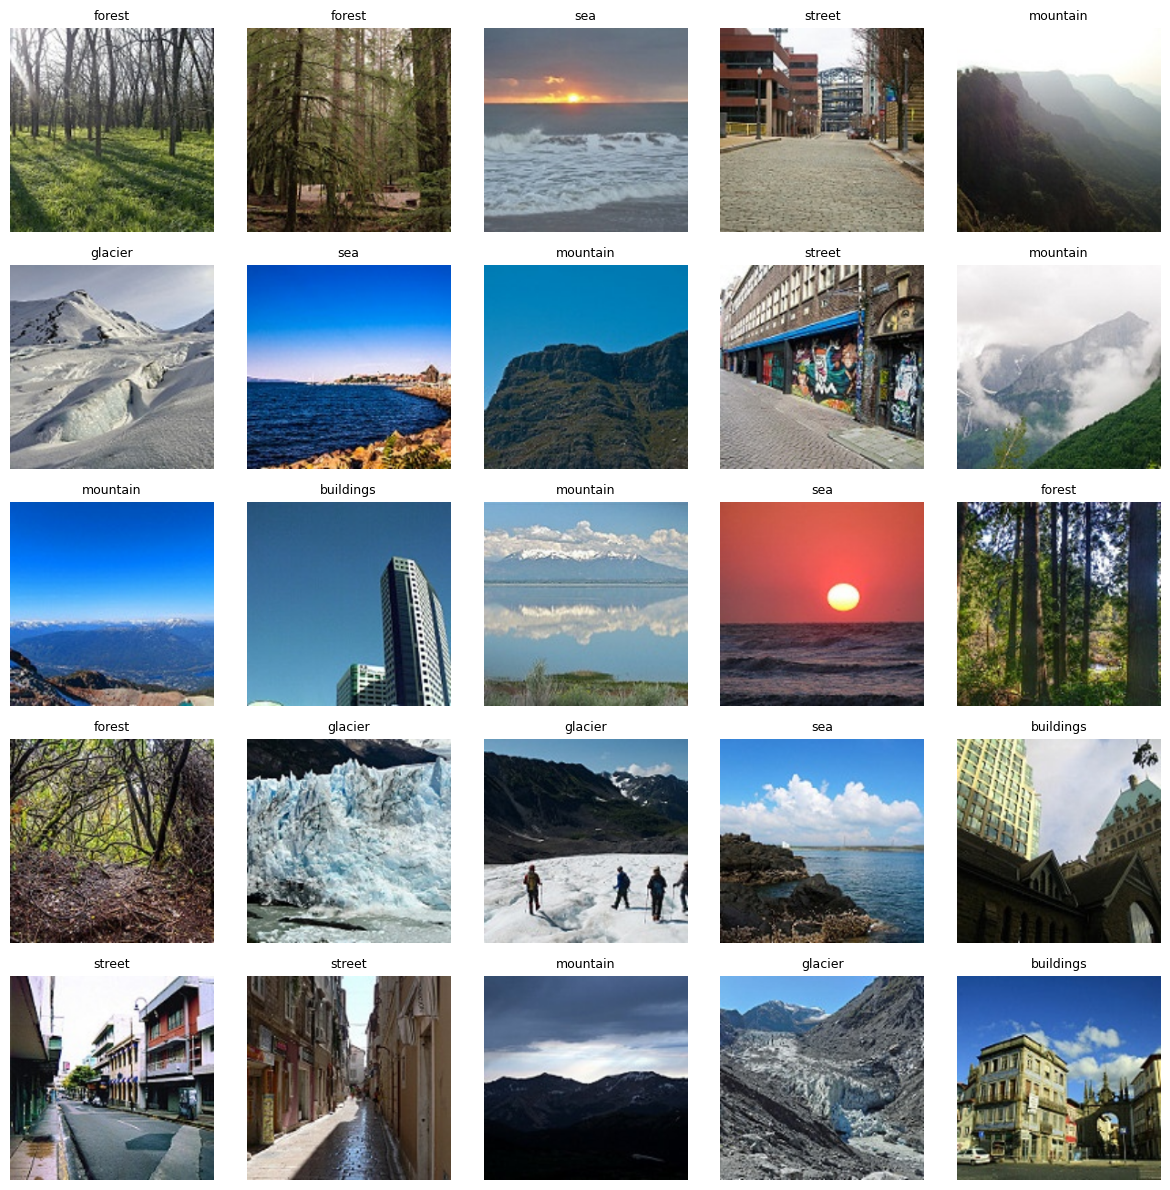

In [7]:
# pick 25 random, distinct indices
idx = np.random.choice(len(X_train), size=25, replace=False)

plt.figure(figsize=(12, 12))
for k, i in enumerate(idx, start=1):
    ax = plt.subplot(5, 5, k)
    ax.imshow((X_train[i] + 1.0) / 2.0)
    # if y_train is one-hot, take argmax; otherwise use the label directly
    label_idx = int(np.argmax(y_train[i])) if getattr(y_train, "ndim", 1) > 1 else int(y_train[i])
    plt.title(class_names[label_idx], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



### Learning Rate Schedulers

In [8]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

In [9]:
# Both these must be input as lr_schedule in train_and_test(....   , lr_schedule=exp_decay, .... )

epochs = 100               # You'll need to adjust this to close to be close to the early stopping location
batch_size = 128

# Needed by LR schedulers

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001,  #  the starting learning rate (before any decay)
    decay_steps=total_steps,     #  how many training steps (batches) before applying decay
    decay_rate=0.98,              #  multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             #  if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #  if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.0001, #  the starting learning rate
    decay_steps=total_steps,      #  number of training steps (batches) over which to decay
    alpha=0.0,                    #  minimum learning rate value as a fraction of initial_learning_rate
                                  #  (final_lr = initial_lr * alpha)
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`.

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).



In [10]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=IMG_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base

base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [ ]:
# Ha, this is very long!

# base.summary()


Model Baseline



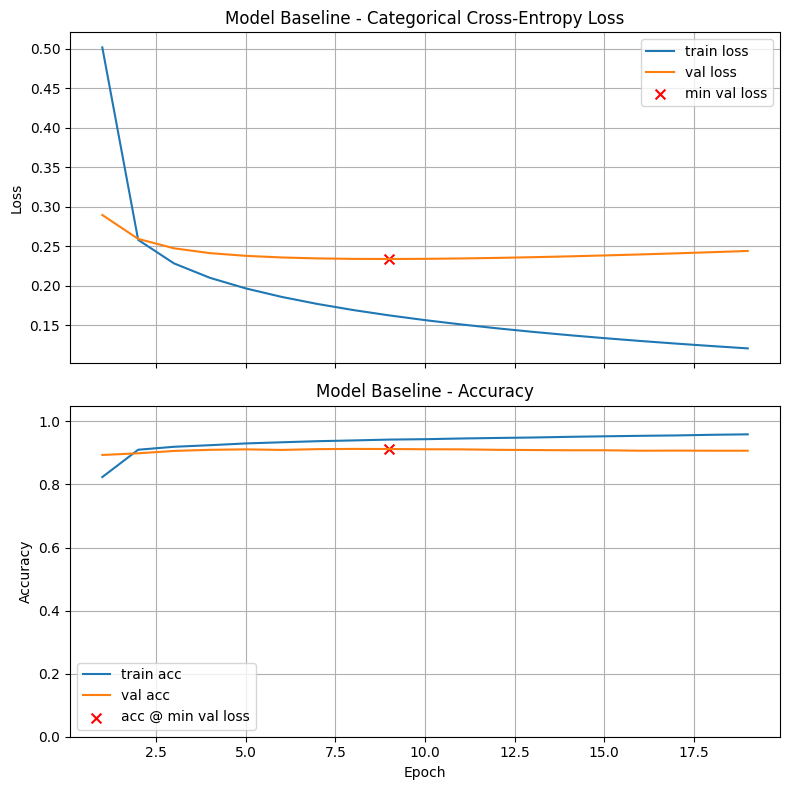

Final Training Loss:            0.1205
Final Training Accuracy:        0.9589
Final Validation Loss:          0.2438
Final Validation Accuracy:      0.9070
Validation Accuracy @ Min Loss: 0.9124

Test Loss: 0.2162
Test Accuracy: 0.9203

Validation-Test Gap (accuracy): 0.007971

Execution Time: 00:03:15


In [11]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()               # default: trainable=False

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')
])

train_and_test(model_baseline, title="Model Baseline")

## Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled()  # default: trainable=False
```


### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads and **give each experiment a unique descriptive title,** i.e., `title="Problem 1 Experiment 1"`
5. **Answer the graded questions.**

### Notes / Constraints

* The descriptive title will be used to compare results at the end of the notebook.
* With `pooling="avg"`, This backbone already applies Global Average Pooling and outputs a **1280-D** feature vector per image. **Do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.



Problem 1 — Exp 1: Small(256)+BN/Dropout, ExpDecay

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.5482 - loss: 1.3624 - val_accuracy: 0.8717 - val_loss: 0.4457 - learning_rate: 9.9980e-05
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8666 - loss: 0.4180 - val_accuracy: 0.8945 - val_loss: 0.3457 - learning_rate: 9.9960e-05
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8941 - loss: 0.3453 - val_accuracy: 0.9013 - val_loss: 0.3182 - learning_rate: 9.9939e-05
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9071 - loss: 0.3079 - val_accuracy: 0.9017 - val_loss: 0.3089 - learning_rate: 9.9919e-05
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9132 - loss: 0.2821 - val_accuracy: 0.9056 - val_loss: 0.3040 - learning_rate: 9.9899e-05
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9236 - loss: 0.2537 - val_accuracy: 0.9070 - val_loss: 0.3007 - learning_rate: 9.9879e-05
Epoch 7/1

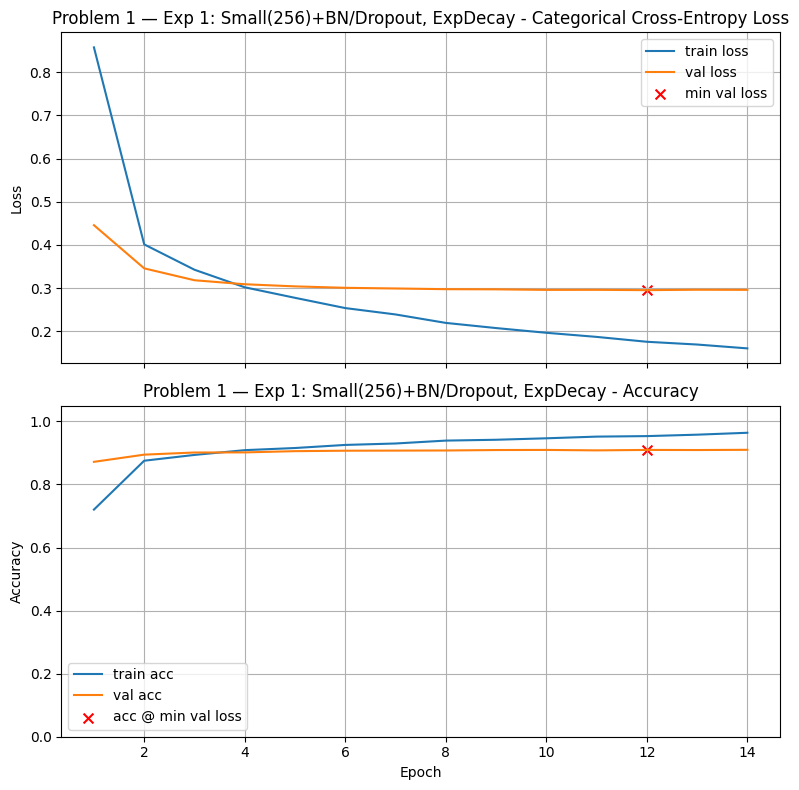

Final Training Loss:            0.1604
Final Training Accuracy:        0.9639
Final Validation Loss:          0.2960
Final Validation Accuracy:      0.9099
Validation Accuracy @ Min Loss: 0.9095

Test Loss: 0.2772
Test Accuracy: 0.9140

Validation-Test Gap (accuracy): 0.004488

Execution Time: 00:01:41

Problem 1 — Exp 2: 512→128+BN/Dropout, FixedLR+Plateau

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 244ms/step - accuracy: 0.4955 - loss: 1.3832 - val_accuracy: 0.8739 - val_loss: 0.4387 - learning_rate: 1.0000e-04
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8454 - loss: 0.4785 - val_accuracy: 0.8913 - val_loss: 0.3219 - learning_rate: 1.0000e-04
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8794 - loss: 0.3672 - val_accuracy: 0.8970 - val_loss: 0.2842 - learning_rate: 1.0000e-04
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8931 - loss: 0.3198 - val_accuracy: 0.9013 - val_loss: 0.2665 - learning_rate: 1.0000e-04
Epoch 5/100
8

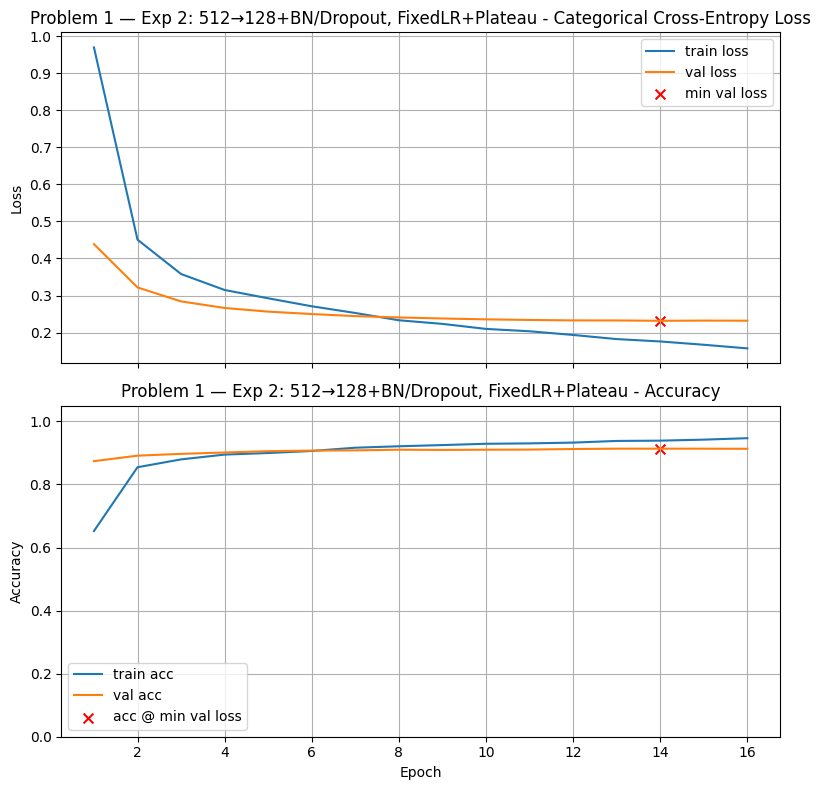

Final Training Loss:            0.1575
Final Training Accuracy:        0.9467
Final Validation Loss:          0.2322
Final Validation Accuracy:      0.9131
Validation Accuracy @ Min Loss: 0.9134

Test Loss: 0.2153
Test Accuracy: 0.9200

Validation-Test Gap (accuracy): 0.006569

Execution Time: 00:01:53

Problem 1 — Exp 3: Linear-Probe+ (Dropout/L2), CosineDecay

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 220ms/step - accuracy: 0.2254 - loss: 2.1385 - val_accuracy: 0.6420 - val_loss: 1.0890
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5330 - loss: 1.2181 - val_accuracy: 0.7848 - val_loss: 0.6965
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6758 - loss: 0.8765 - val_accuracy: 0.8411 - val_loss: 0.5320
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7399 - loss: 0.6898 - val_accuracy: 0.8639 - val_loss: 0.4480
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7798 - loss: 0.5920 - val_accuracy: 0.8742 - val_loss: 

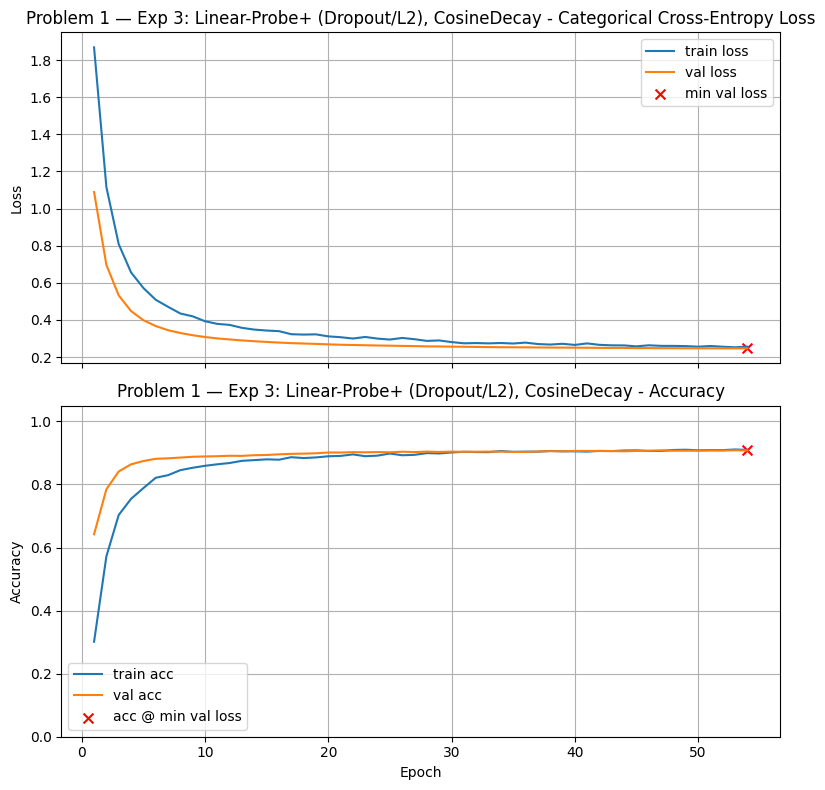

Final Training Loss:            0.2561
Final Training Accuracy:        0.9097
Final Validation Loss:          0.2468
Final Validation Accuracy:      0.9077
Validation Accuracy @ Min Loss: 0.9077

Test Loss: 0.2365
Test Accuracy: 0.9157

Validation-Test Gap (accuracy): 0.008292

Execution Time: 00:04:21
Problem 1 — Exp 2: 512→128+BN/Dropout, FixedLR+Plateau	0.9134	14
Model Baseline                          	0.9113	1
Problem 1 — Exp 1: Small(256)+BN/Dropout, ExpDecay	0.9095	12
Problem 1 — Exp 3: Linear-Probe+ (Dropout/L2), CosineDecay	0.9077	54


In [20]:

def make_head_small():
    # A: very small head with light regularization
    base = make_base_model_pooled(trainable=False)
    return models.Sequential([
        base,
        BatchNormalization(),                # normalize 1280-D features
        Dense(256, activation="relu", kernel_regularizer=l2reg, kernel_initializer=he),
        Dropout(0.25),
        Dense(num_classes, activation="softmax")
    ])

def make_head_medium_bn_drop():
    # B: classic 512→128 MLP with BN+Dropout (no BN before softmax)
    base = make_base_model_pooled(trainable=False)
    return models.Sequential([
        base,
        BatchNormalization(),
        Dense(512, kernel_initializer=he),
        BatchNormalization(),
        ReLU(),
        Dropout(0.40),
        Dense(128, kernel_initializer=he),
        BatchNormalization(),
        ReLU(),
        Dropout(0.30),
        Dense(num_classes, activation="softmax")
    ])

def make_head_linear_probe_plus():
    # C: "linear probe+" = tiny head (regularized), good as a strong simple baseline
    base = make_base_model_pooled(trainable=False)
    return models.Sequential([
        base,
        Dropout(0.50),                       # regularize the frozen features directly
        Dense(num_classes,
              activation="softmax",
              kernel_regularizer=regularizers.l2(5e-4))
    ])

# Run 3 experiments
hist1 = train_and_test(
    make_head_small(),
    title="Problem 1 — Exp 1: Small(256)+BN/Dropout, ExpDecay",
    lr_schedule=exp_decay,
    patience=2,        # short patience
    callbacks=[reduce_lr],
    batch_size=128,
    verbose=1
)

hist2 = train_and_test(
    make_head_medium_bn_drop(),
    title="Problem 1 — Exp 2: 512→128+BN/Dropout, FixedLR+Plateau",
    lr_schedule=1e-4,
    patience=2,
    callbacks=[reduce_lr],
    batch_size=128,
    verbose=1
)

hist3 = train_and_test(
    make_head_linear_probe_plus(),
    title="Problem 1 — Exp 3: Linear-Probe+ (Dropout/L2), CosineDecay",
    lr_schedule=cosine_decay,
    patience=2,
    callbacks=[],
    batch_size=128,
    verbose=1
)


print_results()


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.


**Your answer here:**




In [21]:
# Set a1 to the validation accuracy found by your best model for this problem.

a1 = 0.9134            # Replace 0.0 with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem

print(f'a1 = {a1}')


a1 = 0.9134


The best-performing model was Problem 1 Exp 2: 512→128 with BatchNorm and Dropout, Fixed learning rate plus ReduceLROnPlateau, which reached the highest validation accuracy (0.9134) and showed strong test performance with a small validation–test gap. This head outperformed the others likely because its two dense layers provided more expressive power than the linear probe, while BatchNorm and Dropout helped stabilize training and prevent overfitting. The adaptive learning rate schedule (ReduceLROnPlateau) also allowed the model to converge efficiently without wasting epochs at an overly high rate. Overall, this suggests that when the backbone is frozen, the head design and its regularization strategy play a critical role: a moderately deep head with careful learning rate control can extract the most value from frozen features without overfitting.

## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—don’t add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **unfrozen**. Vary:

   * **Head choice** (pick one from Problem 1).
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**.
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (can combine with a fixed LR).
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 2 Experiment 1"`
3. **Answer the graded questions.**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


Problem 2 — Exp 1: Unfrozen + Fixed LR=1e-5 + Plateau

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 127s 744ms/step - accuracy: 0.2095 - loss: 2.3530 - val_accuracy: 0.3413 - val_loss: 1.4869 - learning_rate: 1.0000e-05
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.3931 - loss: 1.5651 - val_accuracy: 0.5258 - val_loss: 1.2003 - learning_rate: 1.0000e-05
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.5723 - loss: 1.0972 - val_accuracy: 0.6541 - val_loss: 1.0206 - learning_rate: 1.0000e-05
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7092 - loss: 0.8132 - val_accuracy: 0.7228 - val_loss: 0.8750 - learning_rate: 1.0000e-05
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7855 - loss: 0.6566 - val_accuracy: 0.7670 - val_loss: 0.7748 - learning_rate: 1.0000e-05
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8255 - loss: 0.5465 - val_accuracy: 0.7941 - val_loss: 0.6762 - learning_rate: 1.0000e-05
Epoch 7/20


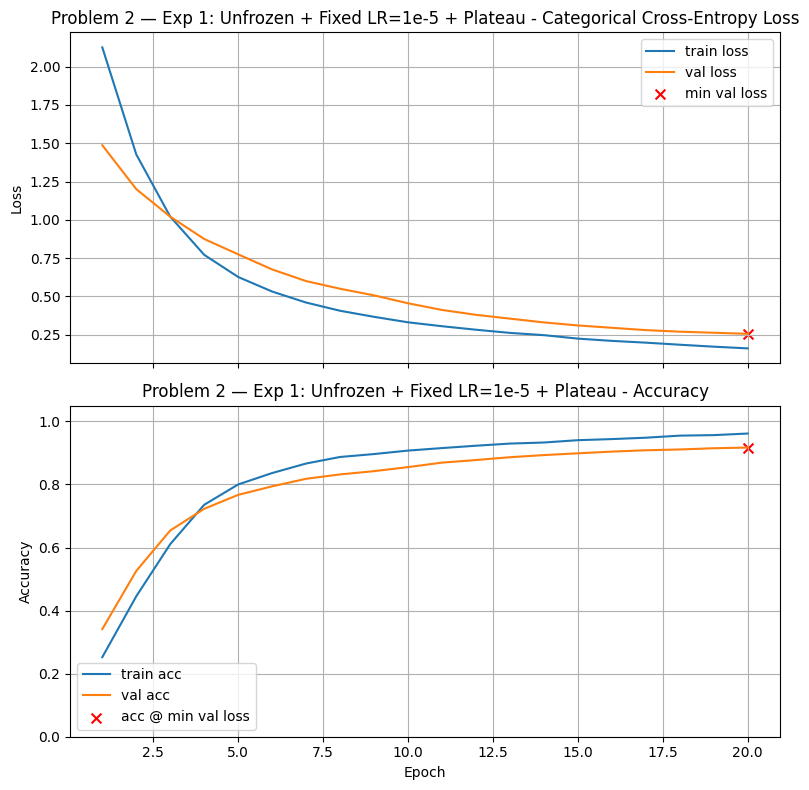

Final Training Loss:            0.1611
Final Training Accuracy:        0.9615
Final Validation Loss:          0.2561
Final Validation Accuracy:      0.9170
Validation Accuracy @ Min Loss: 0.9170

Test Loss: 0.2708
Test Accuracy: 0.9140

Validation-Test Gap (accuracy): 0.002993

Execution Time: 00:04:55

Problem 2 — Exp 2: Unfrozen + CosineDecay (3e-5 →)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 91s 485ms/step - accuracy: 0.3243 - loss: 1.7286 - val_accuracy: 0.7478 - val_loss: 0.7531
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.7768 - loss: 0.6751 - val_accuracy: 0.7952 - val_loss: 0.5500
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8758 - loss: 0.4325 - val_accuracy: 0.8073 - val_loss: 0.5293
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.9066 - loss: 0.3368 - val_accuracy: 0.8201 - val_loss: 0.4936
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9261 - loss: 0.2713 - val_accuracy: 0.8372 - val_loss: 0.4537
Epoch 

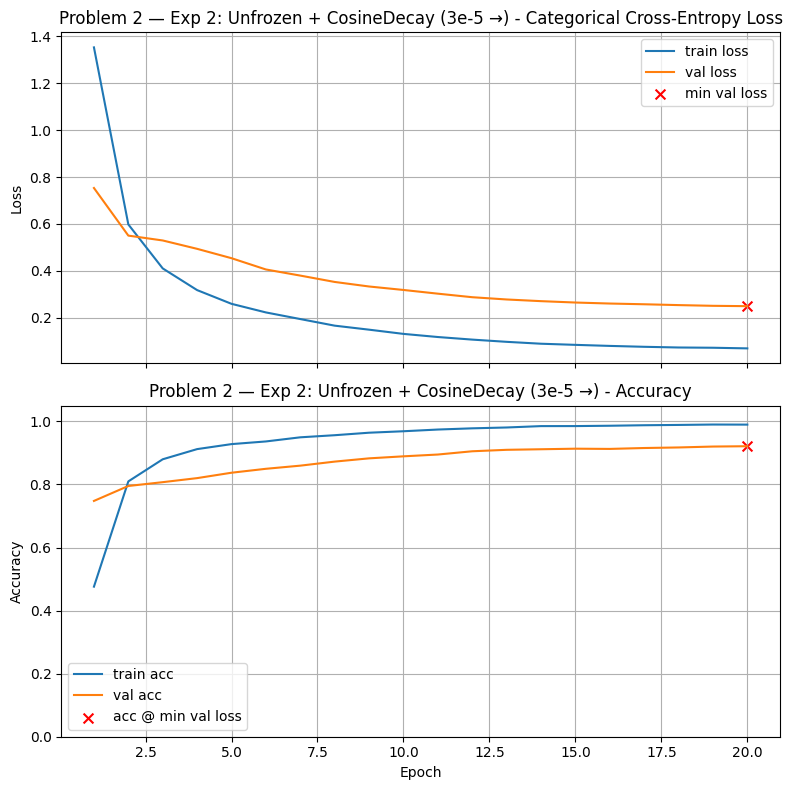

Final Training Loss:            0.0691
Final Training Accuracy:        0.9898
Final Validation Loss:          0.2491
Final Validation Accuracy:      0.9213
Validation Accuracy @ Min Loss: 0.9213

Test Loss: 0.2476
Test Accuracy: 0.9183

Validation-Test Gap (accuracy): 0.002935

Execution Time: 00:04:19

Problem 2 — Exp 3: Unfrozen + ExpDecay (3e-5) + Dropout↑ + L2

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 92s 488ms/step - accuracy: 0.3036 - loss: 1.9664 - val_accuracy: 0.7517 - val_loss: 0.9181 - learning_rate: 2.9970e-05
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.7303 - loss: 0.9348 - val_accuracy: 0.7887 - val_loss: 0.7183 - learning_rate: 2.9939e-05
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8456 - loss: 0.6483 - val_accuracy: 0.8058 - val_loss: 0.6922 - learning_rate: 2.9909e-05
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8851 - loss: 0.5209 - val_accuracy: 0.8151 - val_loss: 0.6829 - learning_rate: 2.9879e-05
Epoch 5/20

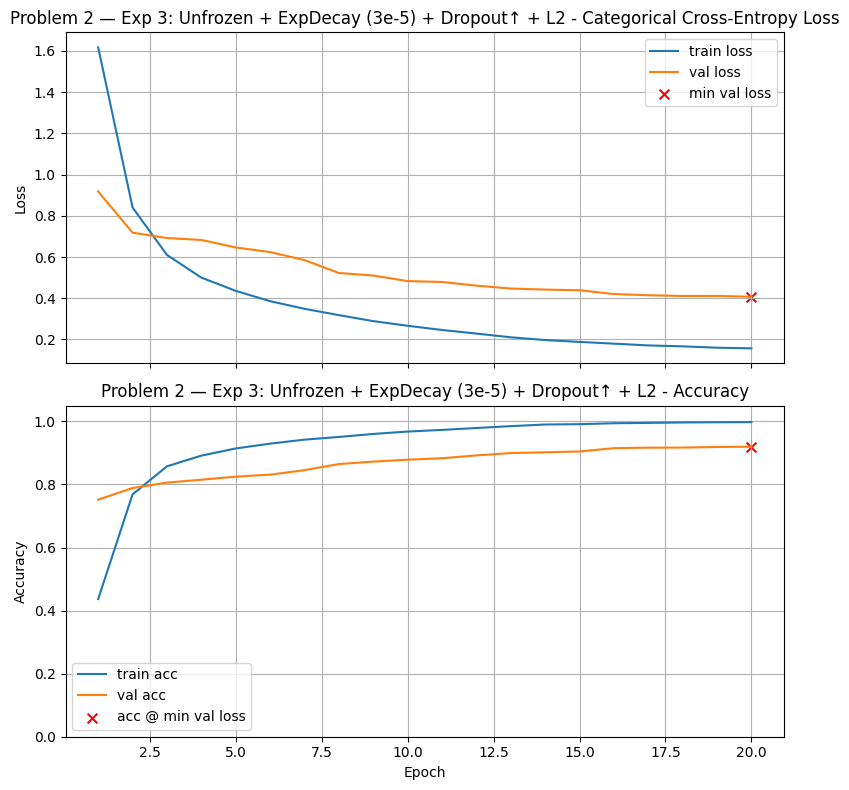

Final Training Loss:            0.1567
Final Training Accuracy:        0.9977
Final Validation Loss:          0.4072
Final Validation Accuracy:      0.9198
Validation Accuracy @ Min Loss: 0.9198

Test Loss: 0.4163
Test Accuracy: 0.9177

Validation-Test Gap (accuracy): 0.002177

Execution Time: 00:04:21
Problem 2 — Exp 2: Unfrozen + CosineDecay (3e-5 →)	0.9213	20
Problem 2 — Exp 3: Unfrozen + ExpDecay (3e-5) + Dropout↑ + L2	0.9198	20
Problem 2 — Exp 1: Unfrozen + Fixed LR=1e-5 + Plateau	0.9170	20
Problem 1 — Exp 2: 512→128+BN/Dropout, FixedLR+Plateau	0.9134	14
Model Baseline                          	0.9113	1
Problem 1 — Exp 1: Small(256)+BN/Dropout, ExpDecay	0.9095	12
Problem 1 — Exp 3: Linear-Probe+ (Dropout/L2), CosineDecay	0.9077	54


In [23]:
# Your code here; add as many cells as you need
def make_unfrozen_head_medium_bn_drop(dropout_top=0.40, dropout_mid=0.30, l2=None):
    base = make_base_model_pooled(trainable=True)  # UNFROZEN backbone
    return models.Sequential([
        base,
        BatchNormalization(),
        Dense(512, kernel_initializer=he, kernel_regularizer=l2),
        BatchNormalization(),
        ReLU(),
        Dropout(dropout_top),
        Dense(128, kernel_initializer=he, kernel_regularizer=l2),
        BatchNormalization(),
        ReLU(),
        Dropout(dropout_mid),
        Dense(num_classes, activation="softmax")
    ])

EPOCHS   = 20
PATIENCE = 4
BATCH    = 128
VERBOSE  = 1

# Re-size schedulers to this run length
steps_per_epoch = int(np.ceil(len(X_train) / BATCH))
total_steps     = EPOCHS * steps_per_epoch

cosine_ft = CosineDecay(
    initial_learning_rate=3e-5,  # tiny LR for full-model FT
    decay_steps=total_steps,
    alpha=0.10                    # floor at 10% of initial LR
)

exp_ft = ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=total_steps,
    decay_rate=0.98,
    staircase=False
)

reduce_lr_fast = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_delta=1e-4,
    min_lr=1e-7,
    verbose=0
)

# Tiny fixed LR + plateau
hist_p2_1 = train_and_test(
    make_unfrozen_head_medium_bn_drop(dropout_top=0.40, dropout_mid=0.30, l2=None),
    title="Problem 2 — Exp 1: Unfrozen + Fixed LR=1e-5 + Plateau",
    lr_schedule=1e-5,
    patience=PATIENCE,
    callbacks=[reduce_lr_fast],
    batch_size=BATCH,
    epochs=EPOCHS,
    verbose=VERBOSE
)

# Cosine schedule (smooth decay), no Plateau (clean contrast)
hist_p2_2 = train_and_test(
    make_unfrozen_head_medium_bn_drop(dropout_top=0.40, dropout_mid=0.30, l2=None),
    title="Problem 2 — Exp 2: Unfrozen + CosineDecay (3e-5 →)",
    lr_schedule=cosine_ft,
    patience=PATIENCE,
    callbacks=[],  # contrast: no ReduceLROnPlateau
    batch_size=BATCH,
    epochs=EPOCHS,
    verbose=VERBOSE
)

# Exponential decay + slightly stronger regularization
hist_p2_3 = train_and_test(
    make_unfrozen_head_medium_bn_drop(dropout_top=0.50, dropout_mid=0.35, l2=regularizers.l2(1e-4)),
    title="Problem 2 — Exp 3: Unfrozen + ExpDecay (3e-5) + Dropout↑ + L2",
    lr_schedule=exp_ft,
    patience=PATIENCE,
    callbacks=[reduce_lr_fast],
    batch_size=BATCH,
    epochs=EPOCHS,
    verbose=VERBOSE
)

print_results()

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your answer here:**





In [24]:
# Set a2 to the validation accuracy found by your best model for this problem.

a2 = 0.9213             # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem

print(f'a2 = {a2:.4f}')

a2 = 0.9213


The best-performing fine-tuning setup was Problem 2  Exp 2 (unfrozen backbone + CosineDecay from 3e-5), which achieved the top validation accuracy (0.9213) with a tiny val–test gap. I designed the three runs to isolate LR behavior while keeping the same 512→128 BN+ReLU+Dropout head: (1) a conservative fixed 1e-5 + ReduceLROnPlateau baseline, (2) a smooth cosine schedule with no plateau callback to avoid abrupt LR drops, and (3) exponential decay paired with slightly stronger regularization (higher dropout + L2) to test overfitting control. The cosine schedule likely won because its gradual, predictable decay let all unfrozen layers adapt without overshooting early or stalling late, while the moderate head capacity and BN/Dropout provided enough flexibility without instability. Overall, when the backbone is unfrozen, a tiny LR with a smooth decay schedule tends to matter more than heavy head regularization—use a modest MLP head, light regularization, and a gentle LR schedule to let the pretrained features adapt effectively.

## Problem Three: Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$** layers to fine-tune. (In Problem 4 you’ll try unfreezing the top **K blocks** instead.)

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model unfreeze the top $N$ layers using the following approach:

    N=20
    model = make_base_model_pooled()
    base_model.trainable = True
    for layer in base_model.layers[:-N]:
        layer.trainable = False

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen.** Vary hyperparameters such as:
   * $N\in \{20,40,60, 80\}$
   * **Head choice** (pick one from Problem 1).
   * **Learning rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay** (your choice of settings).
   * **Early Stopping** settings.
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (you can combine it with a fixed LR).
2. **Run and compare** the three experimentsand **give each experiment a unique descriptive title,** i.e., `title="Problem 3 Experiment 1"`
3. **Answer the graded questions**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


Problem 3 — Exp 1: Unfreeze last 20 + Fixed 1e-5 + Plateau (freeze BN)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.2966 - loss: 1.9002 - val_accuracy: 0.7520 - val_loss: 0.8354 - learning_rate: 1.0000e-05
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6370 - loss: 0.9988 - val_accuracy: 0.8386 - val_loss: 0.5197 - learning_rate: 1.0000e-05
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7795 - loss: 0.6772 - val_accuracy: 0.8803 - val_loss: 0.4044 - learning_rate: 1.0000e-05
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8292 - loss: 0.5403 - val_accuracy: 0.8970 - val_loss: 0.3472 - learning_rate: 1.0000e-05
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8569 - loss: 0.4637 - val_accuracy: 0.9013 - val_loss: 0.3181 - learning_rate: 1.0000e-05
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8733 - loss: 0.4176 - val_accuracy: 0.9024 - val_loss: 0.3006 - learning_rate: 1.0000

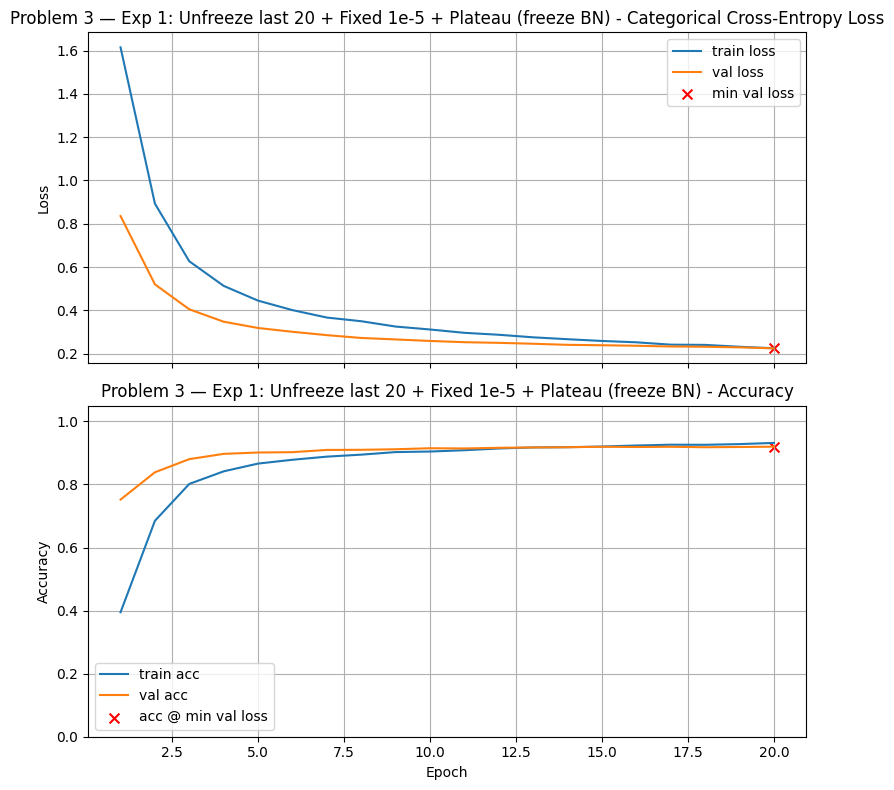

Final Training Loss:            0.2245
Final Training Accuracy:        0.9318
Final Validation Loss:          0.2239
Final Validation Accuracy:      0.9198
Validation Accuracy @ Min Loss: 0.9198

Test Loss: 0.2162
Test Accuracy: 0.9203

Validation-Test Gap (accuracy): 0.000490

Execution Time: 00:02:16

Problem 3 — Exp 2: Unfreeze last 40 + CosineDecay (3e-5→) (freeze BN)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 265ms/step - accuracy: 0.4665 - loss: 1.4291 - val_accuracy: 0.8796 - val_loss: 0.3615
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8661 - loss: 0.4294 - val_accuracy: 0.9081 - val_loss: 0.2723
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9034 - loss: 0.3230 - val_accuracy: 0.9166 - val_loss: 0.2445
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9130 - loss: 0.2739 - val_accuracy: 0.9238 - val_loss: 0.2276
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9233 - loss: 0.2406 - val_accuracy: 0.9277 - val_

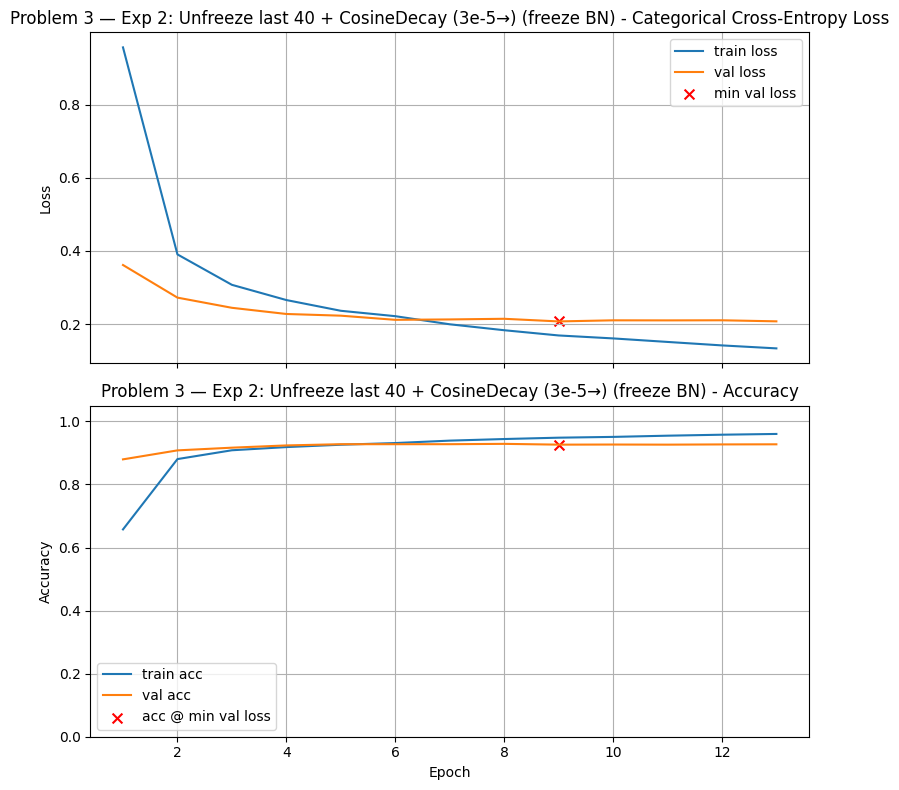

Final Training Loss:            0.1336
Final Training Accuracy:        0.9602
Final Validation Loss:          0.2075
Final Validation Accuracy:      0.9273
Validation Accuracy @ Min Loss: 0.9263

Test Loss: 0.2041
Test Accuracy: 0.9310

Validation-Test Gap (accuracy): 0.004744

Execution Time: 00:01:48

Problem 3 — Exp 3: Unfreeze last 80 + ExpDecay (3e-5) + Dropout↑ + L2

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 59s 347ms/step - accuracy: 0.3162 - loss: 1.9616 - val_accuracy: 0.7292 - val_loss: 0.9454
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7121 - loss: 0.9628 - val_accuracy: 0.7855 - val_loss: 0.7769
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8422 - loss: 0.6629 - val_accuracy: 0.8066 - val_loss: 0.7337
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8832 - loss: 0.5462 - val_accuracy: 0.8197 - val_loss: 0.7083
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9067 - loss: 0.4638 - val_accuracy: 0.8415 - val_

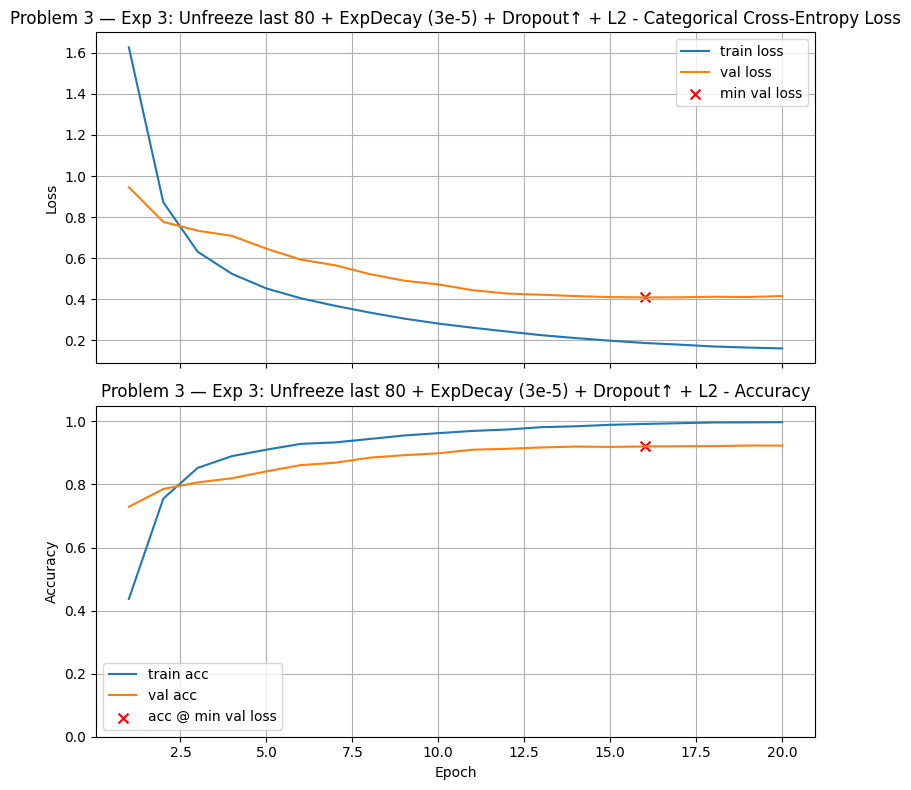

Final Training Loss:            0.1607
Final Training Accuracy:        0.9974
Final Validation Loss:          0.4158
Final Validation Accuracy:      0.9234
Validation Accuracy @ Min Loss: 0.9206

Test Loss: 0.4085
Test Accuracy: 0.9207

Validation-Test Gap (accuracy): 0.000111

Execution Time: 00:02:56
Problem 3 — Exp 2: Unfreeze last 40 + CosineDecay (3e-5→) (freeze BN)	0.9263	9
Problem 2 — Exp 2: Unfrozen + CosineDecay (3e-5 →)	0.9213	20
Problem 3 — Exp 3: Unfreeze last 80 + ExpDecay (3e-5) + Dropout↑ + L2	0.9206	16
Problem 2 — Exp 3: Unfrozen + ExpDecay (3e-5) + Dropout↑ + L2	0.9198	20
Problem 3 — Exp 1: Unfreeze last 20 + Fixed 1e-5 + Plateau (freeze BN)	0.9198	20
Problem 2 — Exp 1: Unfrozen + Fixed LR=1e-5 + Plateau	0.9170	20
Problem 1 — Exp 2: 512→128+BN/Dropout, FixedLR+Plateau	0.9134	14
Model Baseline                          	0.9113	1
Problem 1 — Exp 1: Small(256)+BN/Dropout, ExpDecay	0.9095	12
Problem 1 — Exp 3: Linear-Probe+ (Dropout/L2), CosineDecay	0.9077	54


In [28]:
# Your code here; add as many cells as you need

# === Problem 3: Unfreeze ONLY the last N layers of MobileNetV2 ===
# Backbone already has pooling='avg' — do NOT add another GAP.

def make_partial_unfreeze_head(N, freeze_bn=True, dropout_top=0.40, dropout_mid=0.30, l2=None):
    """
    Unfreeze only the last N layers of MobileNetV2; keep the rest frozen.
    Optionally freeze BN layers (often stabilizes partial fine-tuning).
    """
    base = make_base_model_pooled(trainable=True)  # start unfrozen
    total = len(base.layers)
    N = int(N)
    if N <= 0:
        # freeze all
        for layer in base.layers:
            layer.trainable = False
    elif N < total:
        # freeze everything except last N
        for layer in base.layers[: total - N]:
            layer.trainable = False
    # else: N >= total -> effectively all trainable (rare for Problem 3 but safe)

    if freeze_bn:
        for layer in base.layers:
            if isinstance(layer, BatchNormalization):
                layer.trainable = False

    model = models.Sequential([
        base,
        BatchNormalization(),
        Dense(512, kernel_initializer=he, kernel_regularizer=l2),
        BatchNormalization(),
        ReLU(),
        Dropout(dropout_top),
        Dense(128, kernel_initializer=he, kernel_regularizer=l2),
        BatchNormalization(),
        ReLU(),
        Dropout(dropout_mid),
        Dense(num_classes, activation="softmax")
    ])
    return model

# ---- fast-but-reasonable knobs ----
EPOCHS   = 20
PATIENCE = 4
BATCH    = 128
VERBOSE  = 1

# Schedules sized to this run
steps_per_epoch = int(np.ceil(len(X_train) / BATCH))
total_steps     = EPOCHS * steps_per_epoch

cosine_p3 = CosineDecay(
    initial_learning_rate=3e-5,
    decay_steps=total_steps,
    alpha=0.10
)

exp_p3 = ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=total_steps,
    decay_rate=0.98,
    staircase=False
)

reduce_lr_fast = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2,
    min_delta=1e-4, min_lr=1e-7, verbose=0
)

# --------------- Problem 3 — Experiment 1 (N=20) ----------------
# Conservative: small N, fixed LR + Plateau, BN frozen for stability
hist3_1 = train_and_test(
    make_partial_unfreeze_head(N=20, freeze_bn=True, dropout_top=0.40, dropout_mid=0.30, l2=None),
    title="Problem 3 — Exp 1: Unfreeze last 20 + Fixed 1e-5 + Plateau (freeze BN)",
    lr_schedule=1e-5,
    patience=PATIENCE,
    callbacks=[reduce_lr_fast],
    batch_size=BATCH,
    epochs=EPOCHS,
    verbose=VERBOSE
)

# --------------- Problem 3 — Experiment 2 (N=40) ----------------
# Moderate N, smooth cosine schedule, BN frozen
hist3_2 = train_and_test(
    make_partial_unfreeze_head(N=40, freeze_bn=True, dropout_top=0.40, dropout_mid=0.30, l2=None),
    title="Problem 3 — Exp 2: Unfreeze last 40 + CosineDecay (3e-5→) (freeze BN)",
    lr_schedule=cosine_p3,
    patience=PATIENCE,
    callbacks=[],                     # contrast: no Plateau
    batch_size=BATCH,
    epochs=EPOCHS,
    verbose=VERBOSE
)

# --------------- Problem 3 — Experiment 3 (N=80) ----------------
# Larger N, exponential decay, slightly stronger regularization; BN trainable
hist3_3 = train_and_test(
    make_partial_unfreeze_head(N=80, freeze_bn=False, dropout_top=0.50, dropout_mid=0.35,
                               l2=regularizers.l2(1e-4)),
    title="Problem 3 — Exp 3: Unfreeze last 80 + ExpDecay (3e-5) + Dropout↑ + L2",
    lr_schedule=exp_p3,            # schedule
    patience=PATIENCE,
    callbacks=[],                  # <-- no ReduceLROnPlateau with schedules
    batch_size=BATCH,
    epochs=EPOCHS,
    verbose=VERBOSE
)

print_results()


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your answer here:**




In [29]:
# Set a3 to the validation accuracy found by your best model for this problem.

a3 = 0.9263             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3 = {a3:.4f}')

a3 = 0.9263


The best partial fine-tuning run was Problem 3 Exp 2 (unfreeze last 40 layers + CosineDecay) with a validation accuracy of 0.9263 at epoch 9 and a strong test score (0.9310). I set up three variants to isolate what matters when only the top of the network is trainable: (1) a conservative N=20 with a fixed 1e-5 LR + Plateau and frozen BN for stability, (2) a moderate N=40 with a smooth cosine schedule (also BN frozen), and (3) a larger N=80 with exponential decay plus stronger regularization and BN trainable to test whether extra flexibility helps. The N=40 + cosine combo likely won because it let higher-level features adapt just enough while preserving robust low-level filters; the smooth LR decay avoided abrupt drops, and the 512→128 BN+Dropout head provided sufficient capacity without overfitting. Overall, when unfreezing only the top N layers, a moderate N, gentle LR schedule, and a modest BN+Dropout head tend to balance stability and adaptability better than either very small or very large N with heavier regularization.

## Problem Four: Unfreezing Convolution Blocks

After creating a model, unfreeze the top $K$ conv block using the following approach:

    block_prefixes = [
        'block_1', 'block_2', 'block_3', 'block_4',
        'block_5', 'block_6', 'block_7', 'block_8',
        'block_9', 'block_10', 'block_11', 'block_12',
        'block_13', 'block_14', 'block_15', 'block_16',
        'Conv_1',   # final 1×1 conv stage before pooling
    ]
    
    K = 3
        
    model = make_base_model_pooled(trainable=False)
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):           # Optional:  Often recommended to keep BN layers frozen
            layer.trainable = False                                         # Optional
        else:                                                               # Optiomal
            layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])




### To Do:

1. **Design at least three experiments** with the model having the **last K stages unfrozen**. Vary:

   * $K \in \{1,2,3,4,5\}$  *(K counts stages/blocks, not individual layers)*
   * **Unfreeze Batch Normalization** Layers or keep them frozen (see "Optional" in above code)
   * **Head choice** (pick one from Problem 1)
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** parameters
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 4 Experiment 1"`
3. **Answer the graded questions.**

**Notes**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).

In [ ]:
# Your code here; add as many cells as you need



### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks.

**Your answer here:**




In [ ]:
# Set a4 to the validation accuracy found by your best model for this problem.

a4 = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4 = {a4:.4f}')

a4 = 0.0000


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework.

This reflection question is worth 5 points.

In [26]:
# Print out summary of validation accuracy for each experiment

print_results()

Problem 2 — Exp 2: Unfrozen + CosineDecay (3e-5 →)	0.9213	20
Problem 2 — Exp 3: Unfrozen + ExpDecay (3e-5) + Dropout↑ + L2	0.9198	20
Problem 2 — Exp 1: Unfrozen + Fixed LR=1e-5 + Plateau	0.9170	20
Problem 1 — Exp 2: 512→128+BN/Dropout, FixedLR+Plateau	0.9134	14
Model Baseline                          	0.9113	1
Problem 1 — Exp 1: Small(256)+BN/Dropout, ExpDecay	0.9095	12
Problem 1 — Exp 3: Linear-Probe+ (Dropout/L2), CosineDecay	0.9077	54


### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your answer here:**




## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

![Screenshot 2025-09-25 at 3.38.21 PM.png](attachment:2f17cb78-416f-4995-9eec-8b50c70dabf8.png)


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### TL;DR Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
